In [1]:
import numpy as np
import scipy
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import nuc_norm_finn_diff as api

np.random.seed(0)

In [57]:
N_omega = 101
free_indices = 27
omega = np.linspace(-2, 2, N_omega)
N_z = 4
z = np.linspace(0, 10*1*10**-3, N_z)
delta_z = np.abs(z[1] - z[0])
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
sdr_cst = []
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)

In [83]:
beta_vec = np.array([0., 0.] + list(np.random.random(2*N_omega - 5)) + [0., 0.])
#1.916*np.exp(-np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2/1.)
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
new_beta = beta/np.sqrt(np.trace(beta@beta))
beta_weight = np.sqrt(np.trace(beta@beta))
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta_weight*new_beta
Q_minus = delta_k - beta_weight*new_beta
n = 0.25*np.trace((scipy.linalg.expm(Q_plus*z[-1]) - scipy.linalg.expm(Q_minus*z[-1])).conj().T@(scipy.linalg.expm(Q_plus*z[-1]) - scipy.linalg.expm(Q_minus*z[-1])))
W_plus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_plus*z[i]) for i in range(1, N_z)]
W_minus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_minus*z[i]) for i in range(1, N_z)]
X = np.vstack(W_plus + W_minus + [np.eye(N_omega)])
n

(0.3687039660690299+0j)

In [84]:
import scipy.linalg


D_plus = scipy.linalg.svd(W_plus[-1])[1]
D_minus = scipy.linalg.svd(W_minus[-1])[1]

In [85]:
ordered_D_plus = np.zeros(N_omega)
for i in range(N_omega):
    pos = np.where(np.round(D_plus[i], 6) == np.round(1/(n*D_minus), 6))[0]
    ordered_D_plus[pos] = D_plus[i]

In [86]:
diff_ordered = scipy.linalg.svd(W_plus[-1] - W_minus[-1])[1]
diff_abs = np.abs(ordered_D_plus - D_minus)

In [87]:
new_D_plus = np.zeros(N_omega)
new_D_minus = np.zeros(N_omega)
for i in range(N_omega):
    pos = np.where(np.round(diff_abs, 6)[i] == np.round(diff_ordered, 6))
    new_D_plus[pos] = ordered_D_plus[i]
    new_D_minus[pos] = D_minus[i]

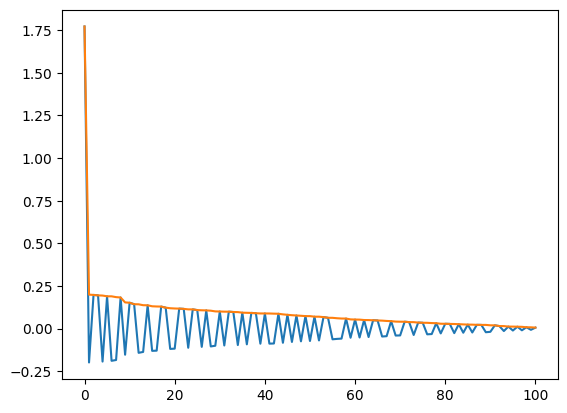

In [88]:
plt.plot((new_D_plus - new_D_minus))
plt.plot(scipy.linalg.svd(W_plus[-1] - W_minus[-1])[1])

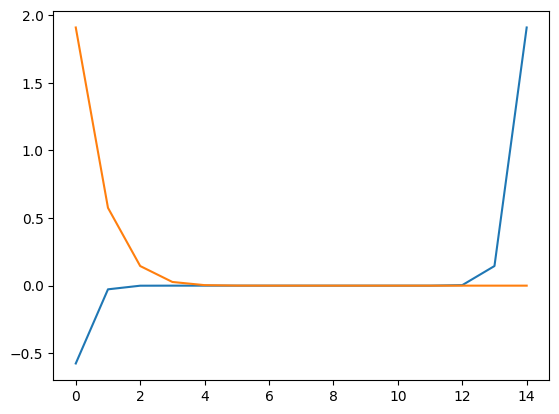

In [6]:
plt.plot((np.sort((ordered_D_plus - D_minus))))
plt.plot(scipy.linalg.svd(W_plus[-1] - W_minus[-1])[1])

In [4]:
constraints_list = []
for i in range(len(projections)):
    sympl = api.symplectic_constr(N_omega, N_z, projections[i], n, sdr_cst[i])
    upper_quad_to_lin = api.quad_to_lin_prop_upper(N_omega, N_z, n, projections[i])
    lower_quad_to_lin = api.quad_to_lin_prop_lower(N_omega, N_z, n, projections[i])
    constraints_list += sympl + upper_quad_to_lin + lower_quad_to_lin
constraints_list.append(api.mean_photon_numb_constr(N_omega, N_z, n))
photon_numb_ineq = api.mean_photon_numb_prev_constr(N_omega, N_z)

In [10]:
# Matrices to give the dynamics
I_proj_Z, proj_plus, proj_minus =api.dynamics_proj_mat(N_omega, z)

In [5]:
[np.trace(constraints_list[i]@X@X.conj().T) for i in range(len(constraints_list)) if np.abs(np.trace(constraints_list[i]@X@X.conj().T)) > 10**-5]

[]

In [6]:
[np.trace(photon_numb_ineq[i]@X@X.conj().T) for i in range(len(photon_numb_ineq)) if np.trace(photon_numb_ineq[i]@X@X.conj().T) > 10**-8]

[]

In [27]:
rand_mat = np.random.random((3, 3)).astype("complex128") + 1.j*np.random.random((3, 3)).astype("complex128")
rand_mat = rand_mat + rand_mat.conj().T
var = cp.Variable(shape = (3,3), hermitian = True)
constraints = [var - rand_mat == np.zeros((3,3))]
problem = cp.Problem(cp.Minimize(0.), constraints)
problem.solve(solver = cp.SCS, verbose = True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 18 04:08:00 PM: Your problem has 9 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 18 04:08:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 18 04:08:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 18 04:08:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 18 04:08:00 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 18 04:08:00 PM: Compiling problem (target solver=SCS).
(CVXPY

0.0

In [7]:
left, right = api.obj_f(N_omega, N_z)

In [36]:
# CVXPY model
var = cp.Variable(shape=((2*N_z - 1)*N_omega,(2*N_z - 1)*N_omega), hermitian = True)
pump = cp.Variable(shape = (N_omega, N_omega), symmetric = True)
constraints = [var >> 0]
constraints += [cp.real(cp.trace(constraints_list[i]@var)) == 0 for i in range(len(constraints_list))]
constraints += [cp.real(cp.trace(sdr_def_constr[i]@var)) == sdr_cst[i] for i in range(len(sdr_def_constr))]
constraints += [proj_plus.conj().T@var@I_proj_Z + I_proj_Z.conj().T@var@proj_minus - (1/np.sqrt(n))*(pump - delta_k) == np.zeros((N_omega, N_omega))]
constraints += [cp.real(cp.trace(photon_numb_ineq[i]@var)) <= 0 for i in range(len(photon_numb_ineq))]
problem = cp.Problem(cp.Minimize(cp.atoms.norm(0.5*left.conj().T@var@right, "nuc")), constraints)

In [37]:
problem.solve(solver = cp.SCS, verbose = True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 18 04:10:13 PM: Your problem has 11250 variables, 4280 constraints, and 0 parameters.
(CVXPY) Apr 18 04:10:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 18 04:10:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 18 04:10:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 18 04:10:13 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 18 04:10:13 PM: Compiling problem (target solver=SCS).

9.373423962045153e-15

In [40]:
end_product = var.value
pump_value = pump.value

In [48]:
U_plus_1 = end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, :N_omega]
U_minus_1 = end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, (N_z - 2)*N_omega:(N_z - 1)*N_omega]

In [54]:
scipy.linalg.eigvalsh(end_product)

array([0.10033144, 0.10033144, 0.10050051, 0.10050051, 0.10064681,
       0.10064681, 0.10076877, 0.10076877, 0.10086507, 0.10086507,
       0.10093461, 0.10093461, 0.10097665, 0.10097665, 0.10099072,
       0.11784376, 0.11784376, 0.11804859, 0.11804859, 0.11827355,
       0.11827355, 0.11850564, 0.11850564, 0.11872616, 0.11872616,
       0.11891145, 0.11891145, 0.11903632, 0.11903632, 0.11908056,
       0.13177429, 0.13193476, 0.13193476, 0.13240761, 0.13240761,
       0.13317046, 0.13317046, 0.13419455, 0.13419455, 0.1354513 ,
       0.1354513 , 0.13691585, 0.13691585, 0.1385679 , 0.1385679 ,
       0.99600847, 0.99600847, 0.9970699 , 0.9970699 , 0.99796664,
       0.99796664, 0.9986994 , 0.9986994 , 0.99926874, 0.99926874,
       0.9996751 , 0.9996751 , 0.99991879, 0.99991879, 1.        ,
       1.7650492 , 1.7650492 , 1.77955037, 1.77955037, 1.79407371,
       1.79407371, 1.80855831, 1.80855831, 1.82286192, 1.82286192,
       1.83658055, 1.83658055, 1.84826605, 1.84826605, 1.85341

# Stuff for LP. Useless now

In [8]:
proj = projections[3*N_omega + 3]
lin_plus = sparse.vstack([(2/(3*delta_z))*proj, -(1/(12*delta_z))*proj, sparse.csc_matrix((4*N_omega, N_omega)), -(2/(3*delta_z))*proj, (1/(12*delta_z))*proj, -(1/np.sqrt(n))*proj])
lin_minus = sparse.vstack([sparse.csc_matrix((2*N_omega, N_omega)), (2/(3*delta_z))*proj, -(1/(12*delta_z))*proj, -(2/(3*delta_z))*proj, (1/(12*delta_z))*proj, sparse.csc_matrix((2*N_omega, N_omega)), (1/np.sqrt(n))*proj])
cst = (1/np.sqrt(n))*np.trace(proj.conj().T@delta_k)
np.trace(lin_plus.conj().T@X) - cst, np.trace(lin_minus.conj().T@X) - cst

((-0.0006934205535392424+0.00015560863798502744j),
 (0.0006934205535385762+0.00015560863798502744j))

In [9]:
constr_plus = {"real":[],
               "imag":[]}
constr_minus = {"real":[],
               "imag":[]}
# Note: the constant part is always imaginary
cst_list = []
terms = [1., 1.j]
for i in range(len(projections)):
    for j in range(len(terms)):
        proj = terms[j]*projections[i].copy()
        constr_plus[list(constr_plus.keys())[j]].append(sparse.vstack([(2/(3*delta_z))*proj, -(1/(12*delta_z))*proj, sparse.csc_matrix((4*N_omega, N_omega)), -(2/(3*delta_z))*proj, (1/(12*delta_z))*proj, -(1/np.sqrt(n))*proj]))
        constr_minus[list(constr_plus.keys())[j]].append(sparse.vstack([sparse.csc_matrix((2*N_omega, N_omega)), (2/(3*delta_z))*proj, -(1/(12*delta_z))*proj, -(2/(3*delta_z))*proj, (1/(12*delta_z))*proj, sparse.csc_matrix((2*N_omega, N_omega)), (1/np.sqrt(n))*proj]))
    cst_list.append(np.imag((1/np.sqrt(n))*np.trace(projections[i].conj().T@delta_k)))

In [17]:
(1/np.sqrt(n))*(delta_k + beta)

array([[0.        -2.08328507j, 0.        +0.j        ,
        0.63164496+0.j        , 0.01999245+0.j        ,
        0.31413316+0.j        , 0.68766484+0.j        ,
        0.30215717+0.j        , 0.64375116+0.j        ,
        0.44662372+0.j        , 0.14111555+0.j        ,
        0.31070356+0.j        , 0.59369969+0.j        ,
        0.6154782 +0.j        , 0.59824161+0.j        ,
        0.68040176+0.j        ],
       [0.        +0.j        , 0.63164496-1.78567291j,
        0.01999245+0.j        , 0.31413316+0.j        ,
        0.68766484+0.j        , 0.30215717+0.j        ,
        0.64375116+0.j        , 0.44662372+0.j        ,
        0.14111555+0.j        , 0.31070356+0.j        ,
        0.59369969+0.j        , 0.6154782 +0.j        ,
        0.59824161+0.j        , 0.68040176+0.j        ,
        0.6792585 +0.j        ],
       [0.63164496+0.j        , 0.01999245+0.j        ,
        0.31413316-1.48806076j, 0.68766484+0.j        ,
        0.30215717+0.j        , 0.6437

In [18]:
(1/delta_z)*((1/60)*W_plus[2] - (3/20)*W_plus[1] + 0.75*W_plus[0] - 0.75*W_minus[0].conj().T + (3/20)*W_minus[1].conj().T - (1/60)*W_minus[2].conj().T) - (1/np.sqrt(n))*(delta_k + beta)

array([[7.18348137e-07-1.85225685e-07j, 8.01518624e-07-1.84786534e-07j,
        8.50439327e-07-1.77706707e-07j, 9.14537981e-07-1.46603622e-07j,
        9.55232816e-07-1.33209324e-07j, 9.73597059e-07-1.07535074e-07j,
        1.01597743e-06-6.57744066e-08j, 1.08526037e-06-3.05219858e-08j,
        1.10872177e-06+1.33910721e-08j, 1.06896552e-06+3.52195224e-08j,
        1.14676154e-06+7.35689113e-08j, 1.17498897e-06+1.12045335e-07j,
        1.22573643e-06+1.71958037e-07j, 1.14507222e-06+1.84755221e-07j,
        1.05792645e-06+1.90945777e-07j],
       [8.01518624e-07-1.84786534e-07j, 8.93634656e-07-1.82557846e-07j,
        9.47904534e-07-1.72825199e-07j, 1.01800333e-06-1.36504715e-07j,
        1.06282076e-06-1.20847238e-07j, 1.08230234e-06-9.16391659e-08j,
        1.12826170e-06-4.42372964e-08j, 1.20405692e-06-3.18743039e-09j,
        1.22874610e-06+4.62098122e-08j, 1.18406032e-06+6.92864613e-08j,
        1.26927233e-06+1.13962837e-07j, 1.29945074e-06+1.57423891e-07j,
        1.35398642e-06+

In [10]:
[0.5*np.trace(constr_plus["real"][i].conj().T@X + X.conj().T@constr_plus["real"][i]) for i in range(len(constr_plus["real"])) if np.abs(0.5*np.trace(constr_plus["real"][i].conj().T@X + X.conj().T@constr_plus["real"][i])) > 10**-3]

[]

In [11]:
[0.5*np.trace(constr_plus["imag"][i].conj().T@X + X.conj().T@constr_plus["imag"][i]) - cst_list[i] for i in range(len(constr_plus["imag"])) if np.abs(0.5*np.trace(constr_plus["imag"][i].conj().T@X + X.conj().T@constr_plus["imag"][i]) - cst_list[i]) > 10**-3]

[]

In [12]:
[0.5*np.trace(constr_minus["imag"][i].conj().T@X + X.conj().T@constr_minus["imag"][i]) - cst_list[i] for i in range(len(constr_minus["imag"])) if np.abs(0.5*np.trace(constr_minus["imag"][i].conj().T@X + X.conj().T@constr_minus["imag"][i]) - cst_list[i]) > 10**-3]

[]

In [13]:
[np.trace(constr_minus["real"][i].conj().T@X + X.conj().T@constr_minus["real"][i]) for i in range(len(constr_minus["real"])) if np.abs(np.trace(constr_minus["real"][i].conj().T@X + X.conj().T@constr_minus["real"][i])) > 10**-3]

[(0.0010829667755563044+0j),
 (0.001129925494023451+0j),
 (0.0012428534818089698+0j),
 (0.001230889383409206+0j),
 (0.0013137282956661167+0j),
 (0.0013147772430153193+0j),
 (0.0013254773804022846+0j),
 (0.0013962636087114788+0j),
 (0.0014206573857040716+0j),
 (0.0014238184001262866+0j),
 (0.0014689802205781755+0j),
 (0.0015222277264590467+0j),
 (0.0014503565459490497+0j),
 (0.001376036696655536+0j),
 (0.0012507373269738942+0j),
 (0.0011299254940234787+0j),
 (0.001178884718447959+0j),
 (0.0012947908169117506+0j),
 (0.0012816644395567955+0j),
 (0.0013657940397890922+0j),
 (0.0013671990994201244+0j),
 (0.0013774458210322749+0j),
 (0.0014499271945263015+0j),
 (0.0014751673340316351+0j),
 (0.0014780291704952764+0j),
 (0.001523667134417206+0j),
 (0.0015796267476524406+0j),
 (0.0015036378946540196+0j),
 (0.0014278070006021881+0j),
 (0.001296631215232602+0j),
 (0.0012428534818080816+0j),
 (0.0012947908169116396+0j),
 (0.0014208974131180163+0j),
 (0.0014039006313495417+0j),
 (0.0014979382630541

In [62]:
obj_f = sparse.vstack([sparse.csc_matrix((N_omega, N_omega)), sparse.eye(N_omega), sparse.csc_matrix((N_omega, N_omega)), -sparse.eye(N_omega), sparse.csc_matrix((5*N_omega, N_omega))])

In [85]:
i = 1
(0.5*cp.real(cp.trace(constr_plus["imag"][i].conj().T@X + X.conj().T@constr_plus["imag"][i])) - cst_list[i]).value

5.9946919037552615e-06

In [92]:
variable = cp.Variable(shape=(9*N_omega, N_omega), complex = True)
constraints = [0.5*cp.real(cp.trace(constr_plus["real"][i].conj().T@variable + variable.conj().T@constr_plus["real"][i])) == 0 for i in range(len(constr_plus["real"]))]
constraints += [0.5*cp.real(cp.trace(constr_plus["imag"][i].conj().T@variable + variable.conj().T@constr_plus["imag"][i])) - cst_list[i] == 0 for i in range(len(constr_plus["imag"]))]
constraints += [0.5*cp.real(cp.trace(constr_minus["real"][i].conj().T@variable + variable.conj().T@constr_minus["real"][i])) == 0 for i in range(len(constr_minus["real"]))]
constraints += [0.5*cp.real(cp.trace(constr_minus["imag"][i].conj().T@variable + variable.conj().T@constr_minus["imag"][i])) - cst_list[i] ==0 for i in range(len(constr_minus["imag"]))]
problem = cp.Problem(cp.Minimize(cp.atoms.norm(obj_f.conj().T@variable)), constraints)

In [93]:
problem.solve(solver = cp.SCS, verbose = True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 17 02:44:04 PM: Your problem has 2025 variables, 900 constraints, and 0 parameters.


(CVXPY) Apr 17 02:44:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 02:44:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 02:44:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 02:44:04 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 02:44:04 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 17 02:44:04 PM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 17 02:44:04 PM: Applying reduction Complex2Real
(CVXPY) Apr 17 02:44:05 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 17 02:44:05 

2.7755575615628914e-17

In [94]:
end_product = variable.value

In [104]:
U_plus = [end_product[:N_omega], end_product[N_omega:2*N_omega]]
U_minus = [end_product[2*N_omega:3*N_omega], end_product[3*N_omega:4*N_omega]]
U_plus_dagger = [end_product[4*N_omega:5*N_omega], end_product[5*N_omega:6*N_omega]]
U_minus_dagger = [end_product[6*N_omega:7*N_omega], end_product[7*N_omega:8*N_omega]]
opt_beta = end_product[8*N_omega:]

In [106]:
U_minus[0]@U_plus_dagger[0]

array([[2.19735449e-03+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 1.61438289e-03+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 1.12109923e-03+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j

In [102]:
U_plus[0]

array([[0.-0.04687595j, 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        ],
       [0.+0.j        , 0.-0.04017938j, 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        ],
       [0.+0.j        , 0.+0.j        , 0.-0.03348282j, 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        ],
       [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.-0.02678626j,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j       